- Link for Tableau Dashboard


https://public.tableau.com/authoring/Telecom-IneffectiveOperators/Dashboard1#2

## TITLE: Identifying Ineffective Operators¶


## Project description:
The virtual telephony service CallMeMaybe is developing a new function that will give supervisors information on the least effective operators. An operator is considered ineffective if they have a large number of missed incoming calls (internal and external) and a long waiting time for incoming calls. Moreover, if an operator is supposed to make outgoing calls, a small number of them is also a sign of ineffectiveness.

we will:

Carry out exploratory data analysis
Identify ineffective operators
Test statistical hypotheses
### Description of the data
The datasets contain data on the use of the virtual telephony service CallMeMaybe. Its clients are organizations that need to distribute large numbers of incoming calls among various operators, or make outgoing calls through their operators. Operators can also make internal calls to communicate with one another. These calls go through CallMeMaybe's network.

### Project objective
Create a new function that will give supervisors information on the least effective operators

### Import libraries

In [1]:
import pandas as pd  
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
from termcolor import colored
from scipy import stats as st
import math as mth

### Import and look in the Data

In [89]:
#Local import of the data
try:
    clients=pd.read_csv('telecom_clients_us.csv')
    operators=pd.read_csv('telecom_dataset_us.csv')
    
#When we load data from the cloud
except:
    clients=pd.read_csv('/datasets/telecom_clients_us.csv')
    operators=pd.read_csv('/datasets/telecom_dataset_us.csv')

In [90]:
union = operators.merge(clients,how='left',on='user_id')

In [91]:
union.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,B,2019-08-01
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,B,2019-08-01
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,B,2019-08-01
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,B,2019-08-01
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,B,2019-08-01


In [92]:
union.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53902 entries, 0 to 53901
Data columns (total 11 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
tariff_plan            53902 non-null object
date_start             53902 non-null object
dtypes: bool(1), float64(1), int64(4), object(5)
memory usage: 4.6+ MB


- While missing values are related to the operators would be more wise to remove them and avoid to fill them since we have high responsibility on rating an operator as innefective or not within inaccurate data
- Operator id and user id(client) would be better to transform it to int32 to save some memory.

### Data preprocessing 

In [93]:
#drop the rows with nan
operator_nulls=union[~union['operator_id'].isnull()]
display(operator_nulls.head())
print('The {} null lines of the attribute internal is the {:.2%} of the rest of data set'\
      .format(operator_nulls['internal'].isnull().sum(),\
              (operator_nulls['internal'].isnull().sum()/operator_nulls.shape[0])))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,B,2019-08-01
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,B,2019-08-01
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,B,2019-08-01
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,B,2019-08-01
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29,B,2019-08-01


The 60 null lines of the attribute internal is the 0.13% of the rest of data set


In [94]:
#Investigate the nulls
look_nulls=union[union['operator_id'].isnull()]
look_nulls.groupby(['date','tariff_plan'])\
.agg({'is_missed_call':'value_counts','internal':'value_counts','direction':'value_counts'}).head()

is_missed_call  internal  direction
2019-08-02 00:00:00+03:00 B False             NaN       1.0        NaN
                            True              1.0       NaN        NaN
                          C False             NaN       1.0        NaN
                            True              1.0       NaN        NaN
2019-08-03 00:00:00+03:00 B False             NaN       3.0        NaN

- Direction in missed calls is not recorded at all. Maybe we should trasfer this to the related department as a potential technical issue. 

In [95]:
#drop the rest nan of internal variable
df=operator_nulls[~operator_nulls['internal'].isnull()]
df.isnull().sum()

user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
tariff_plan            0
date_start             0
dtype: int64

In [96]:
#check for duplicates
print('There are {} duplicates'.format(df.duplicated().sum()))
df_clean=df[~df.duplicated()]
df_clean=df_clean.reset_index(drop=True)
df_clean.info()

There are 4179 duplicates
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41491 entries, 0 to 41490
Data columns (total 11 columns):
user_id                41491 non-null int64
date                   41491 non-null object
direction              41491 non-null object
internal               41491 non-null object
operator_id            41491 non-null float64
is_missed_call         41491 non-null bool
calls_count            41491 non-null int64
call_duration          41491 non-null int64
total_call_duration    41491 non-null int64
tariff_plan            41491 non-null object
date_start             41491 non-null object
dtypes: bool(1), float64(1), int64(4), object(5)
memory usage: 3.2+ MB


In [97]:
df_clean['operator_id']=df_clean['operator_id'].astype('int32')
df_clean['user_id']=df_clean['user_id'].astype('int32')
df_clean['direction']=df_clean['direction'].astype('category')
df_clean['internal']=df_clean['internal'].astype('category')
df_clean['is_missed_call']=df_clean['is_missed_call'].astype('category')
df_clean['tariff_plan']=df_clean['tariff_plan'].astype('category')
df_clean['date_start']=df_clean['date_start'].astype('datetime64[D]')
df_clean['date']=df_clean['date'].astype('datetime64[D]')

In [98]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41491 entries, 0 to 41490
Data columns (total 11 columns):
user_id                41491 non-null int32
date                   41491 non-null datetime64[ns]
direction              41491 non-null category
internal               41491 non-null category
operator_id            41491 non-null int32
is_missed_call         41491 non-null category
calls_count            41491 non-null int64
call_duration          41491 non-null int64
total_call_duration    41491 non-null int64
tariff_plan            41491 non-null category
date_start             41491 non-null datetime64[ns]
dtypes: category(4), datetime64[ns](2), int32(2), int64(3)
memory usage: 2.1 MB


In [99]:
df_clean.describe(include='all')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
count,41491.000000,41491,41491,41491,41491.000000,41491,41491.000000,41491.000000,41491.000000,41491,41491
unique,NaN,118,2,2,NaN,2,NaN,NaN,NaN,3,65
top,NaN,2019-11-24 00:00:00,out,False,NaN,False,NaN,NaN,NaN,C,2019-10-16 00:00:00
freq,NaN,987,28813,36161,NaN,27382,NaN,NaN,NaN,14811,2360
first,NaN,2019-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-01 00:00:00
last,NaN,2019-11-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-31 00:00:00
mean,167301.113543,NaN,NaN,NaN,916516.771155,NaN,16.921381,1010.940011,1323.153238,NaN,NaN
std,600.513986,NaN,NaN,NaN,21234.081589,NaN,59.786187,4066.666485,4788.953155,NaN,NaN
min,166377.000000,NaN,NaN,NaN,879896.000000,NaN,1.000000,0.000000,0.000000,NaN,NaN
25%,166782.000000,NaN,NaN,NaN,900790.000000,NaN,1.000000,0.000000,67.000000,NaN,NaN


* We see that the most popular date the data were retrieved was the 2019-11-24. 
* 28813 of calls out of 41491 are outgoing 
* Where 36161 are external. 
* 41491-27382=14109 are the missed calls
* The most popular tariff plan is the C
* The data are for clients that registered from 2019-08-01 till 2019-10-31
* The day with the most registrations is the 2019-10-16 with 2360 new clients in that day.

* Define the attribute wait_duration = total_call_duration-call_duration.(We need this to identify the corrupted,anomaly, rows and remove them)

In [100]:
df_clean['wait_duration']=df_clean['total_call_duration']-df_clean['call_duration']

- Check for anomalies in the data, for example very short calls or short wait_duration

In [101]:
#check average waiting time for the missed calls
df_clean[df_clean['is_missed_call']==True]['wait_duration'].describe()

count    14109.000000
mean       445.463038
std       1544.636841
min          0.000000
25%         18.000000
50%         80.000000
75%        326.000000
max      45312.000000
Name: wait_duration, dtype: float64

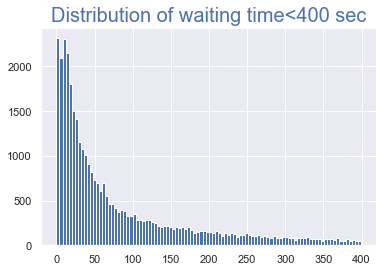

In [102]:
#distribution of waiting time<400 sec
df_clean[df_clean['wait_duration']<400]['wait_duration'].hist(bins=100)
plt.title('Distribution of waiting time<400 sec',fontsize=20,color='b')
plt.show()

In [103]:
df_clean[(df_clean['wait_duration']<400) & (df_clean['is_missed_call']==True)]['wait_duration'].describe()

count    11041.000000
mean        86.680373
std         99.539626
min          0.000000
25%         12.000000
50%         45.000000
75%        130.000000
max        399.000000
Name: wait_duration, dtype: float64

In [104]:
#Let's see how many short waiting periods are missed calls for incoming calls
#incoming=df_clean['direction']=='in']
df_clean[(df_clean['wait_duration']<20)\
         & (df_clean['is_missed_call']==True) & (df_clean['direction']=='in')].head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,wait_duration
573,166405,2019-08-18,in,False,882684,True,1,0,7,B,2019-08-02,7
574,166405,2019-08-18,in,False,882686,True,1,0,5,B,2019-08-02,5
597,166405,2019-08-23,in,False,882684,True,1,0,14,B,2019-08-02,14
709,166405,2019-09-08,in,False,882686,True,1,0,8,B,2019-08-02,8
814,166405,2019-09-26,in,False,882684,True,1,0,16,B,2019-08-02,16


- 696 people were impatient to wait on the phone and hang it up within less 20 sec.We shouldn't take into account this missed calls in order to evaluate the effectiveness of an operator. Is not reliable.We will drop these rows
* There are rows that were classified as missed calls but there is call_duration time(maybe due to some technical issue), we should isolate this anomalies and subtracted them from the rest data

In [105]:
false_missed_classified=df_clean[(df_clean['is_missed_call']==True) & (df_clean['call_duration']>0)]
display(false_missed_classified.head(3))
df_clean2=df_clean[~df_clean.index.isin(false_missed_classified.index)]
df_clean2=df_clean2.reset_index(drop='all')
df_clean2.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,wait_duration
1261,166405,2019-11-18,in,False,939478,True,1,165,173,B,2019-08-02,8
1287,166405,2019-11-20,in,False,882686,True,1,1,5,B,2019-08-02,4
1306,166405,2019-11-21,in,False,882686,True,1,1,5,B,2019-08-02,4


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,wait_duration
0,166377,2019-08-04,out,True,880022,True,3,0,5,B,2019-08-01,5
1,166377,2019-08-04,out,True,880020,True,1,0,1,B,2019-08-01,1
2,166377,2019-08-04,out,True,880020,False,1,10,18,B,2019-08-01,8


- We will move out the missed calls with `wait_duration <15` since 
it wouldn't be fair to evaluate as inneficient an operator when the median 
of waiting duration is 80 sec and the mean 86.
- Also we can't consider as an outgoing call from an operator when it has wait_duration 1-2 sec, hence we shouldn't invole this observations in our analysis cause are metrics that give efficiency value to an operator which would have been not fair for the rest of his colleageus.

In [106]:
low_wait=df_clean2[(df_clean2['wait_duration']<15)\
                   & (df_clean2['is_missed_call']==True) & (df_clean2['calls_count']>1)]
low_wait.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,wait_duration
0,166377,2019-08-04,out,True,880022,True,3,0,5,B,2019-08-01,5
8,166377,2019-08-05,out,True,881278,True,2,0,5,B,2019-08-01,5
17,166377,2019-08-08,out,False,880028,True,2,0,2,B,2019-08-01,2
18,166377,2019-08-08,out,False,880022,True,2,0,10,B,2019-08-01,10
31,166377,2019-08-13,out,True,880026,True,2,0,0,B,2019-08-01,0


In [107]:
df_clean3=df_clean2[~df_clean2.index.isin(low_wait.index)]
df_clean3=df_clean3.reset_index(drop=True)

In [108]:
#Check number of operators per client
operators_per_client=df_clean3.groupby('operator_id').agg({'user_id':'nunique'})
print('{} operators with more than one client.'\
      .format(len(operators_per_client[operators_per_client['user_id']>1])))

#plans per operator
plan_per_operators=df_clean3.groupby('operator_id').agg({'tariff_plan':'nunique'})

print('{} operators with more than one tariff_plan.'\
      .format(len(plan_per_operators[plan_per_operators['tariff_plan']>1])))

0 operators with more than one client.
0 operators with more than one tariff_plan.


- Check distribution of mean duration time of calls per operator for the whole time period of the data.Mean call duration per day and break it down also this per client, and then for internal/external and last level for incoming/outgoing calls

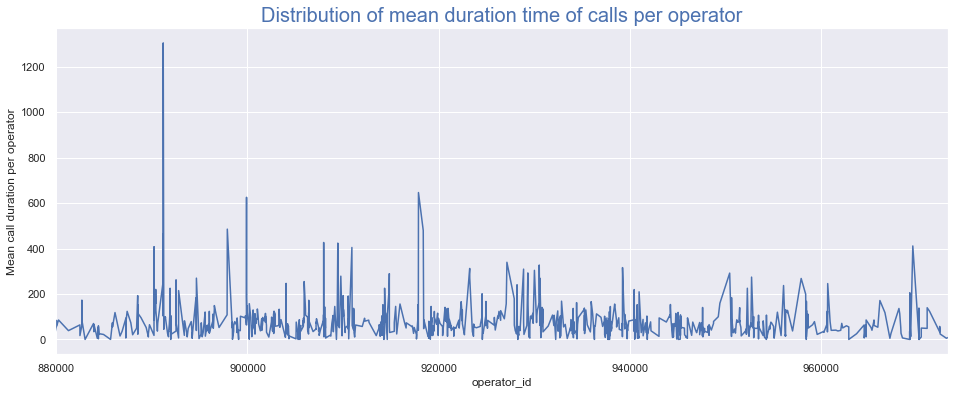

In [109]:
#Check distribution of mean duration time of call per operator for all time period of data
mean_call=df_clean3.groupby('operator_id').agg({'call_duration':'sum','calls_count':'sum',})
mean_call['call_mean_duration']=mean_call['call_duration']/mean_call['calls_count']

#mean duration call per operator
mean_call['call_mean_duration'].plot(figsize=(16,6))
plt.title('Distribution of mean duration time of calls per operator',fontsize=20,color='b')
plt.ylabel('Mean call duration per operator')
plt.show()

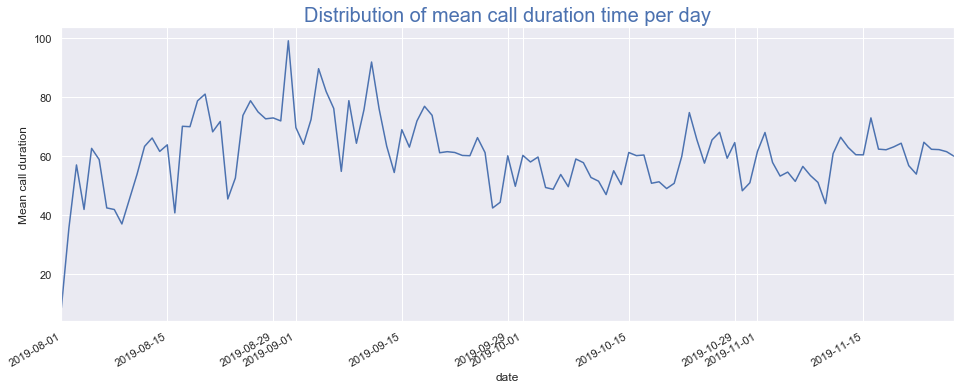

In [110]:
#Check distribution of mean duration time per day
mean_call_day=df_clean3.groupby('date').agg({'call_duration':'sum','calls_count':'sum',})
mean_call_day['call_mean_duration_day']=mean_call_day['call_duration']/mean_call_day['calls_count']

#mean duration call per operator
mean_call_day['call_mean_duration_day'].plot(figsize=(16,6))
plt.title('Distribution of mean call duration time per day',fontsize=20,color='b')
plt.ylabel('Mean call duration')
plt.show()

* Mean call duration between 15th of August to 15th September is higher than the rest days

In [111]:
mean_call.head()

,call_duration,calls_count,call_mean_duration
operator_id,,,
879896,63862,922,69.264642
879898,257389,7309,35.215351
880020,2245,37,60.675676
880022,15147,181,83.685083
880026,153326,2217,69.159224


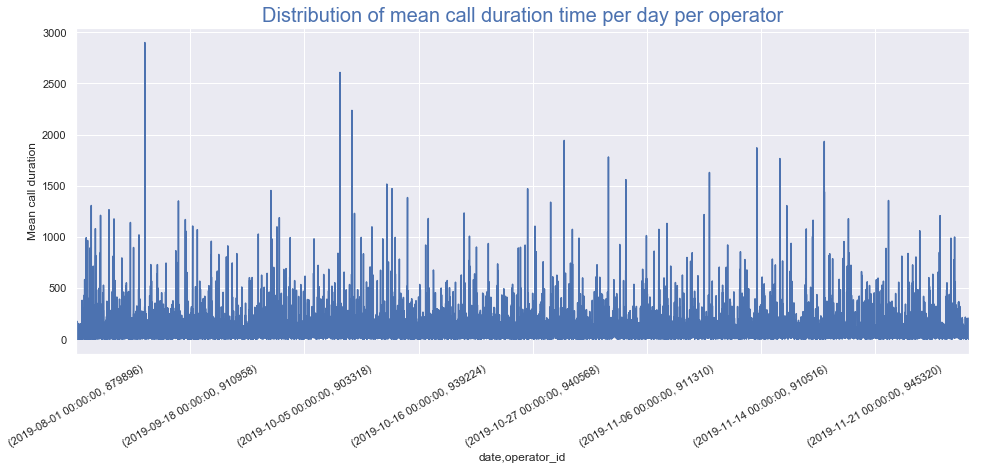

In [112]:
#Check distribution of call mean duration time per day per operator
mean_call_day_operator=df_clean3.groupby(['date','operator_id']).agg({'call_duration':'sum','calls_count':'sum',})
mean_call_day_operator['call_mean_duration_day_oper']=\
mean_call_day_operator['call_duration']/mean_call_day_operator['calls_count']

#mean duration call per operator
mean_call_day_operator['call_mean_duration_day_oper'].plot(figsize=(16,6))
plt.title('Distribution of mean call duration time per day per operator',fontsize=20,color='b')
plt.xticks(rotation=30)
plt.ylabel('Mean call duration')
plt.show()

* We see some operators to be far away from the others. We should consider those as outliers, and not take then into account when we wanna estimate the thresholds about our business metrics

In [113]:
mean_call.head()

,call_duration,calls_count,call_mean_duration
operator_id,,,
879896,63862,922,69.264642
879898,257389,7309,35.215351
880020,2245,37,60.675676
880022,15147,181,83.685083
880026,153326,2217,69.159224


,call_duration,calls_count,call_mean_duration
operator_id,,,
891154,243908,525,464.586667
918390,118018,246,479.747967
890232,13484,33,408.606061
910926,10125,25,405.000000
897894,9230,19,485.789474
969600,7823,19,411.736842
909452,3394,8,424.250000
891192,1306,1,1306.000000
907974,1281,3,427.000000


These Top operators are the 0.03% of operators.


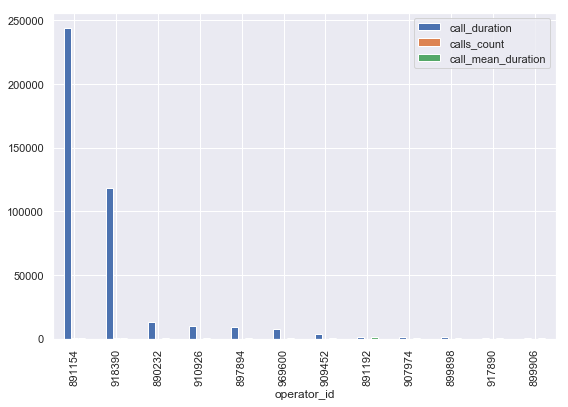

In [116]:
#get those operators with high mean call duration
top_operators=mean_call[mean_call['call_mean_duration']>400].sort_values('call_duration',ascending=False)
top_operators.plot(kind='bar',figsize=(9,6))
display(top_operators)
print(colored('These Top operators are the {:.2%} of operators.'\
      .format(top_operators.shape[0]/df_clean3.shape[0]),on_color='on_yellow'))

In [117]:
df_clean3.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,wait_duration
0,166377,2019-08-04,out,True,880020,True,1,0,1,B,2019-08-01,1
1,166377,2019-08-04,out,True,880020,False,1,10,18,B,2019-08-01,8
2,166377,2019-08-04,out,False,880022,True,3,0,25,B,2019-08-01,25
3,166377,2019-08-04,out,False,880020,False,2,3,29,B,2019-08-01,26
4,166377,2019-08-04,out,False,880020,True,8,0,50,B,2019-08-01,50


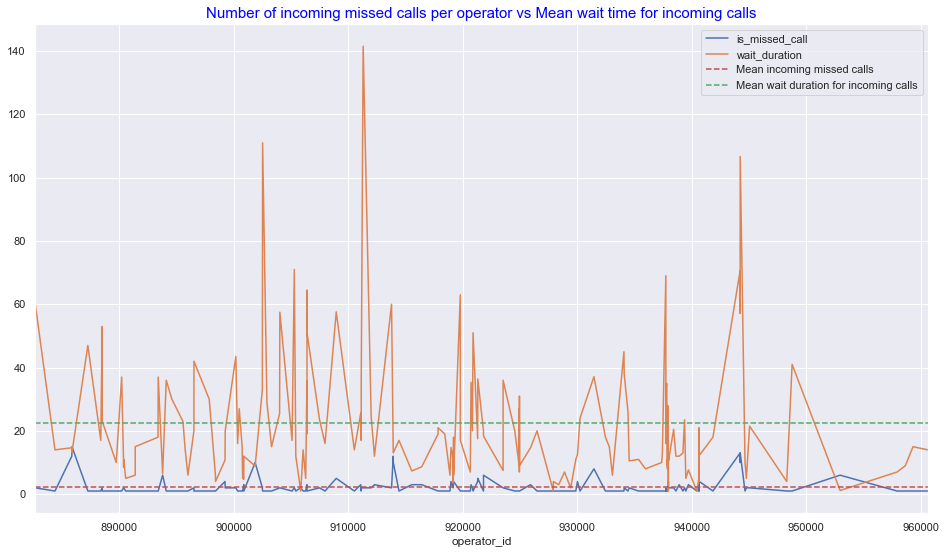

The mean number of incoming missed calls is 2.37
40 operators out of 167 have more than 3 incoming missed calls.
The mean time of incoming waiting calls is 22.56


In [118]:
#for incoming calls. Internal and external
incoming_missed_wait=df_clean3[(df_clean3['is_missed_call']==True) & (df_clean3['direction']=='in')]\
.groupby('operator_id').agg({'is_missed_call':'count','wait_duration':'mean'})
incoming_missed_wait.plot(figsize=(16,9))
plt.axhline(y=2.37,linestyle='--',color='r',label='Mean incoming missed calls')
plt.axhline(y=22.56,linestyle='--',color='g',label='Mean wait duration for incoming calls')
plt.title('Number of incoming missed calls per operator vs Mean wait time for incoming calls'\
          ,fontsize=15,color='blue')
plt.legend()
plt.show()
print(colored('The mean number of incoming missed calls is {:.2f}'.\
     format(incoming_missed_wait['is_missed_call'].mean()),on_color='on_yellow'))
print(colored('{} operators out of {} have more than 3 incoming missed calls.'\
      .format(incoming_missed_wait[incoming_missed_wait['is_missed_call']>=3].shape[0],\
             incoming_missed_wait.shape[0]),on_color='on_yellow'))
print(colored('The mean time of incoming waiting calls is {:.2f}'.\
     format(incoming_missed_wait['wait_duration'].mean()),on_color='on_yellow'))

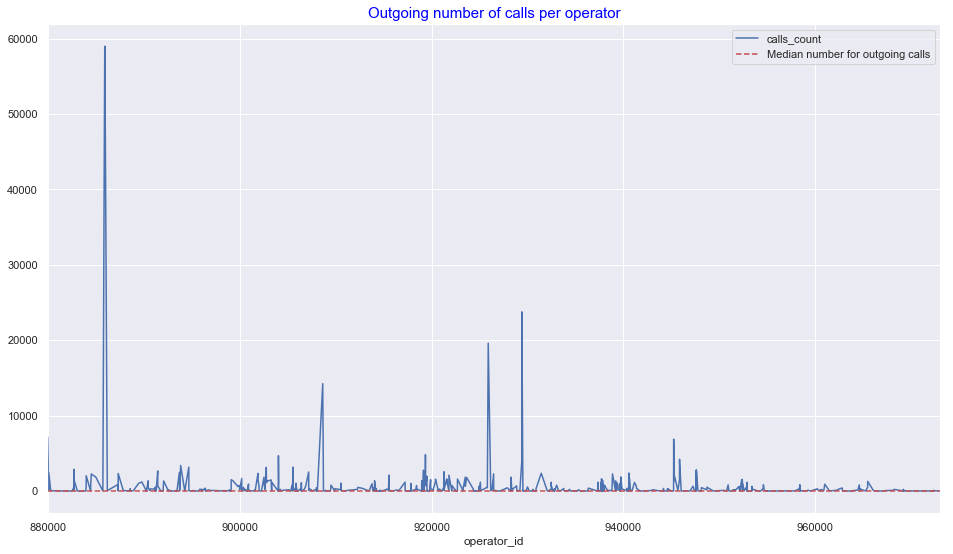

The median number of outgoing calls is 18.0


In [119]:
#for outgoing, the number of calls per operator
df_clean3[df_clean3['direction']=='out'].groupby('operator_id').agg({'calls_count':'sum'}).plot(figsize=(16,9))
plt.axhline(y=19,linestyle='--',color='r',label='Median number for outgoing calls')
plt.title('Outgoing number of calls per operator',fontsize=15,color='blue')
plt.legend()
plt.show()
print(colored('The median number of outgoing calls is {}'\
      .format(df_clean3[df_clean3['direction']=='out']\
              .groupby('operator_id').agg({'calls_count':'count'})['calls_count'].median()),on_color='on_yellow'))

### Testing hypotheses

- Null hypothesis H0: Is the mean number of incoming missed calls the same between the tariffs?
- Alternative hypothesis H1: it is not

In [120]:
df_clean.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,wait_duration
0,166377,2019-08-04,out,True,880022,True,3,0,5,B,2019-08-01,5
1,166377,2019-08-04,out,True,880020,True,1,0,1,B,2019-08-01,1
2,166377,2019-08-04,out,True,880020,False,1,10,18,B,2019-08-01,8
3,166377,2019-08-04,out,False,880022,True,3,0,25,B,2019-08-01,25
4,166377,2019-08-04,out,False,880020,False,2,3,29,B,2019-08-01,26


In [121]:
#We will test the hypothesis in raw data
#sample for tarrif A
sampleA=df_clean[(df_clean['direction']=='in') & (df_clean['is_missed_call']==True) & (df_clean['tariff_plan']=='A')]\
.groupby('date',as_index=False).agg({'is_missed_call':'count'})['is_missed_call']

#sample for tarrif B
sampleB=df_clean[(df_clean['direction']=='in') & (df_clean['is_missed_call']==True) & (df_clean['tariff_plan']=='B')]\
.groupby('date',as_index=False).agg({'is_missed_call':'count'})['is_missed_call']

#sample for tarrif C
sampleC=df_clean[(df_clean['direction']=='in') & (df_clean['is_missed_call']==True) & (df_clean['tariff_plan']=='C')]\
.groupby('date',as_index=False).agg({'is_missed_call':'count'})['is_missed_call']

In [122]:
#checking the normality of our samples
#for sampleA
print('For sampleA')
alpha = .05 # significance level

results = st.shapiro(sampleA)
p_value = results[1] # the second value in the array of results (with index 1) - the p-value

print('p-value: ', p_value)

if (p_value < alpha):
    print("Null hypothesis rejected: the distribution is not normal")
else:
    print("Failed to reject the null hypothesis: the distribution seems to be normal") 
    
print('================================')

print('For sampleB')
alpha = .05 # significance level

results = st.shapiro(sampleB)
p_value = results[1] # the second value in the array of results (with index 1) - the p-value

print('p-value: ', p_value)

if (p_value < alpha):
    print("Null hypothesis rejected: the distribution is not normal")
else:
    print("Failed to reject the null hypothesis: the distribution seems to be normal") 
    
print('================================')

print('For sampleC')
alpha = .05 # significance level

results = st.shapiro(sampleC)
p_value = results[1] # the second value in the array of results (with index 1) - the p-value

print('p-value: ', p_value)

if (p_value < alpha):
    print("Null hypothesis rejected: the distribution is not normal")
else:
    print("Failed to reject the null hypothesis: the distribution seems to be normal") 

For sampleA
p-value:  1.4012692339804289e-08
Null hypothesis rejected: the distribution is not normal
For sampleB
p-value:  5.82504935664474e-06
Null hypothesis rejected: the distribution is not normal
For sampleC
p-value:  5.379479262046516e-06
Null hypothesis rejected: the distribution is not normal


- Since our samples are not normal we will choose a no parametric test. The MannWhitney test.
- Along side we will apply the Bonferroni correction to the alpha value since we will run more than one test at the same data

In [123]:
#apply The MannWhitney test and Bonferroni correction
#Number of tests=3, hence alpha=0.05/3
print('Test comparison between the sampleA,sampleB:')

alpha = .0167 #significance level

results = st.mannwhitneyu(sampleA, sampleB)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Null hypothesis rejected: the difference is statistically significant")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference")
    
print('====================================')

print('Test comparison between the sampleB,sampleC:')

alpha = .0167 #significance level

results = st.mannwhitneyu(sampleB, sampleC)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Null hypothesis rejected: the difference is statistically significant")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference") 
    
print('====================================')

print('Test comparison between the sampleA,sampleC:')

alpha = .0167 #significance level

results = st.mannwhitneyu(sampleA, sampleC)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Null hypothesis rejected: the difference is statistically significant")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference") 

Test comparison between the sampleA,sampleB:
p-value:  0.4140369189116001
Failed to reject the null hypothesis: we can't make conclusions about the difference
Test comparison between the sampleB,sampleC:
p-value:  0.14962590680256427
Failed to reject the null hypothesis: we can't make conclusions about the difference
Test comparison between the sampleA,sampleC:
p-value:  0.272293961589138
Failed to reject the null hypothesis: we can't make conclusions about the difference


- Means of incoming missed calls between the tariffs are most likely the same

### Working with business metrics and indicators

In [124]:
#1st metric : missed incoming missed calls - the less the better
metric1=df_clean[(df_clean['is_missed_call']==True) & (df_clean['direction']=='in')]\
.groupby('operator_id',as_index=False).agg({'is_missed_call':'count'})

#set the threshold that splits the innefective and effective operators within this metric
threshold1=metric1['is_missed_call'].mean()

#2nd metric : Mean wait_duration for incoming calls - the less the better
metric2=df_clean[df_clean['direction']=='in'].groupby('operator_id',as_index=False).agg({'wait_duration':'mean'})

#threshold for metric2
threshold2=metric2['wait_duration'].mean()


#3rd metric : Number of outgoing calls (with waiting time >5 sec for missed_calls)-the more the better
#for outgoing missed calls
metric3_missed=df_clean[(df_clean['is_missed_call']==True)\
                        & (df_clean['direction']=='out') & (df_clean['wait_duration']>5)]\
.groupby('operator_id',as_index=False).agg({'calls_count':'sum'})

#threshold for metric3_missed 
threshold3=metric3_missed['calls_count'].median()

#for not missed - the more the better
metric3=df_clean[(df_clean['is_missed_call']==False) & (df_clean['direction']=='out')]\
.groupby('operator_id',as_index=False).agg({'calls_count':'sum'})
#same threshold for here, the threshold3

In [125]:
#i=operator
def evaluation(i):
    metric1=df_clean[(df_clean['is_missed_call']==True) & (df_clean['direction']=='in')]\
    .groupby('operator_id',as_index=False).agg({'is_missed_call':'count'})
    threshold1=metric1['is_missed_call'].mean()
    #===#
    metric2=df_clean[df_clean['direction']=='in'].groupby('operator_id',as_index=False).agg({'wait_duration':'mean'})
    threshold2=metric2['wait_duration'].mean()
    #===#
    metric3_missed=df_clean[(df_clean['is_missed_call']==True)\
                            & (df_clean['direction']=='out') & (df_clean['wait_duration']>5)]\
    .groupby('operator_id',as_index=False).agg({'calls_count':'sum'})
    threshold3=metric3_missed['calls_count'].median()
    #===#
    metric3=df_clean[(df_clean['is_missed_call']==False) & (df_clean['direction']=='out')]\
    .groupby('operator_id',as_index=False).agg({'calls_count':'sum'})
    #===#
    a=0 
    b=0
    c=0
    d=0
    total_score=0
    if i not in list(metric1['operator_id']):  
        a+=0
    elif metric1[metric1['operator_id']==i]['is_missed_call'].item()<threshold1:
        a+=1
    else:
        a+=0
        
    if i not in list(metric2['operator_id']):
        b+=0
    elif metric2[metric2['operator_id']==i]['wait_duration'].item()<threshold2:
        b+=1
    else:
        b+=0

    if i not in list(metric3_missed['operator_id']):
        c+=0
    elif metric3_missed[metric3_missed['operator_id']==i]['calls_count'].item()>threshold3:
        c+=1
    else:
        c+=0
        
    if i not in list(metric3['operator_id']):
        d+=0
    elif metric3[metric3['operator_id']==i]['calls_count'].item()>threshold3:
        d+=1
    else:
        d+=0

    total_score=a+b+c+d
    if total_score>=2:
        
        return 'effective'
    else:
        return 'ineffective'


In [126]:
df_clean['evaluation']=df_clean['operator_id'].apply(lambda x: evaluation(x))

In [127]:
df_clean.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,wait_duration,evaluation
0,166377,2019-08-04,out,True,880022,True,3,0,5,B,2019-08-01,5,effective
1,166377,2019-08-04,out,True,880020,True,1,0,1,B,2019-08-01,1,ineffective
2,166377,2019-08-04,out,True,880020,False,1,10,18,B,2019-08-01,8,ineffective
3,166377,2019-08-04,out,False,880022,True,3,0,25,B,2019-08-01,25,effective
4,166377,2019-08-04,out,False,880020,False,2,3,29,B,2019-08-01,26,ineffective


effective      34109
ineffective     7382
Name: evaluation, dtype: int64

The 17.79% of the operators are ineffective


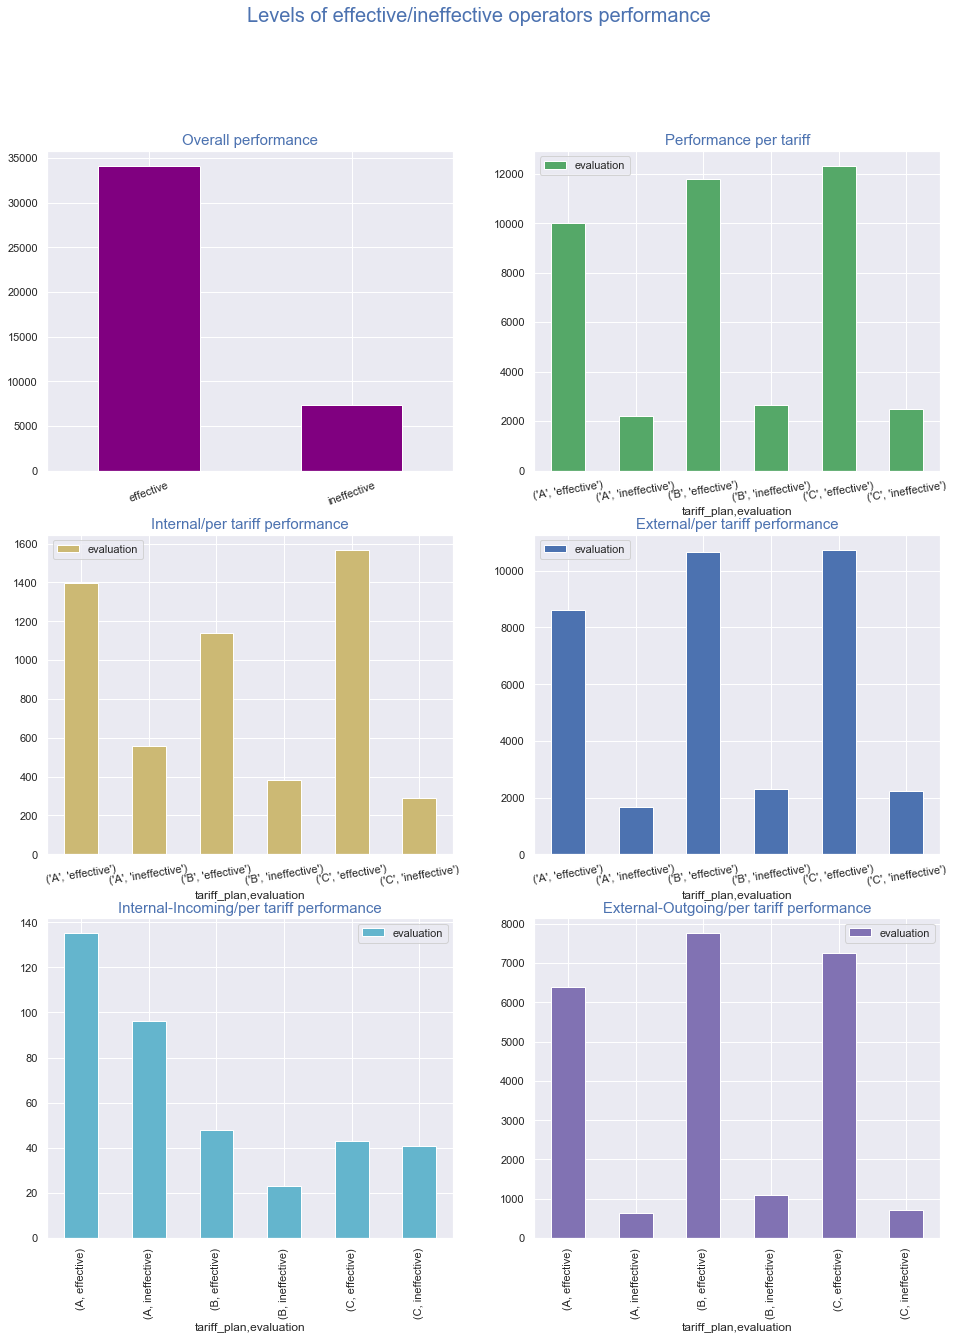

In [128]:
fig,axes=plt.subplots(3,2,figsize=(16,20))
display(df_clean['evaluation'].value_counts())
print(colored('The {:.2%} of the operators are ineffective'\
              .format(df_clean['evaluation'].value_counts()[1]/df_clean['evaluation']\
                      .value_counts().sum()),on_color='on_yellow'))

#total effective ineffective operators
df_clean['evaluation'].value_counts().plot(kind='bar',ax=axes[0,0],color='purple')
axes[0,0].set_xticklabels(df_clean['evaluation'].value_counts().index,rotation=20)
axes[0,0].set_title('Overall performance',fontsize=15,color='b')

#break it down to each tariff
df_clean.groupby('tariff_plan').agg({'evaluation':'value_counts'}).plot(kind='bar',ax=axes[0,1],color='g')
axes[0,1].set_xticklabels(df_clean.groupby('tariff_plan').agg({'evaluation':'value_counts'}).index,rotation=9)
axes[0,1].set_title('Performance per tariff',fontsize=15,color='b')

#break it down to internal/external
df_clean[df_clean['internal']==True].groupby('tariff_plan').agg({'evaluation':'value_counts'})\
.plot(kind='bar',ax=axes[1,0],color='y')
axes[1,0].set_xticklabels(df_clean[df_clean['internal']==True].groupby('tariff_plan')\
                          .agg({'evaluation':'value_counts'}).index,rotation=9)
axes[1,0].set_title('Internal/per tariff performance',fontsize=15,color='b')

df_clean[df_clean['internal']==False].groupby('tariff_plan').agg({'evaluation':'value_counts'})\
.plot(kind='bar',ax=axes[1,1],color='b')
axes[1,1].set_xticklabels(df_clean[df_clean['internal']==False].groupby('tariff_plan')\
                          .agg({'evaluation':'value_counts'}).index,rotation=9)
axes[1,1].set_title('External/per tariff performance',fontsize=15,color='b')

#break it down to incoming / outgoing and internal/external
df_clean[(df_clean['internal']==True) & (df_clean['direction']=='in')].groupby('tariff_plan')\
.agg({'evaluation':'value_counts'}).plot(kind='bar',ax=axes[2,0],color='c')
axes[2,0].set_title('Internal-Incoming/per tariff performance',fontsize=15,color='b')

df_clean[(df_clean['internal']==False) & (df_clean['direction']=='out')].groupby('tariff_plan')\
.agg({'evaluation':'value_counts'}).plot(kind='bar',ax=axes[2,1],color='m')
axes[2,1].set_title('External-Outgoing/per tariff performance',fontsize=15,color='b')

plt.suptitle('Levels of effective/ineffective operators performance',fontsize=20,color='b')
plt.show()

### Conclusions-Recommendations
- While missing values are related to the operators would be more wise to remove them and avoid to fill them since we have high responsibility on rating an operator as innefective or not within inaccurate data

- We see that the most popular date that the data were retrieved was the 2019-11-24.
- 28813 of calls out of 41491 are outgoing Where 36161 are external.
- 41491-27382=14109 are the missed calls
- The most popular tariff plan is the C
- The data are for clients that registered from 2019-08-01 till 2019-10-31
- The day with the most registrations is the 2019-10-16 with 2360 new clients in that day.

696 people were impatient to wait on the phone and hang it up within less 15 sec.We didn't take into account this missed calls in order to evaluate the effectiveness of an operator. Is wouldn't be reliable or fair.We droped these rows.
There are some rows that were classified as missed calls but there is call_duration time(maybe due to some technical issue), we isolated these anomalies and subtracted them from the rest of the data.

- The rest observations have median of waiting duration 80 sec and the mean 86.
Also we can't consider as an outgoing call from an operator when it has wait_duration 1-2 sec, hence we shouldn't invole this observations in our analysis cause are metrics that give virtual efficiency-value to an operator which would have been not fair for the rest of his colleageus.

- We saw some operators to be far away from the others. We considered those as outliers, and not took them into account when we estimated the thresholds about our business metrics

- In data with removed outliers, null values operators and anomalies:

> - The mean number of incoming missed calls is 2.37,
> - 40 operators out of 167 have more than 3 incoming missed calls.
> - The mean time of incoming waiting calls is 22.56
> - The median number of outgoing calls is 18.0


- Test hypothesis showed that Means of incoming missed calls between the tariffs are most likely the same.
- For the construction of the function that we evaluated the operators we worked with 3 metrics, the 3rd splitted in two parts, with 3 different thresholds that separates the effective/ineffective operators
>- #1st metric : missed incoming missed calls - the less the better
>- #2nd metric : Mean wait_duration for incoming calls - the less the better
>- #3rd metric : Number of outgoing calls (with waiting time >5 sec for missed_calls)-the more the better
>> - #for outgoing missed calls
>> - #for not missed 


